# Projet Tri de déchets - Entraînement des CNN

### Membres de l'équipe :
- Amine CHERIF HAOUAT
- Tom LABIAUSSE
- Cyrine NABI
- Pierre OLLIVIER
- Selim BEN TURKIA


## Organisation du notebook :
- [ 0 ] - Installation des packages Keras, Tensorflow, Pydrive, Lime si nécessaire
- [ 1 ] - Importations des modules et fonctions indispensables et connexion à un Google Drive
- [ 2 ] - Définition de diverses fonctionnalités basiques mais utiles pour la suite
- [ 3 ] - Téléchargement des données depuis le Google Drive connecté
- [ 4 ] - Pré-traitement des données téléchargées et organisation des ensembles de photos d'entrainement et de test relativement à une catégorie sélectionnée
- [ 5.1 ] - Entrainement de VGG16 sur les données d'entrainement et évaluation sur les données test
- [ 5.2 ] - Entrainement de ResNet50 sur les données d'entrainement et évaluation sur les données test
- [ 5.3 ] - Entrainement de EfficientNetB3 sur les données d'entrainement et évaluation sur les données test
- [ 6 ] - Interprétation des prédictions avec LIME

# 0 - Installation des packages

Les cellules suivantes doivent être exécutées uniquement si l'utilisateur rencontre des difficultés lors de l'importation des modules en section 1.


In [ ]:
# KERAS
!pip install keras==2.4.3

In [ ]:
# TENSORFLOW
!pip install tensorflow==2.4.1

In [ ]:
# PYDRIVE
!pip install PyDrive

In [ ]:
# LIME
!pip install lime

# 1 - Importations

In [ ]:
# Import des modules PyDrive et authentificaiton via Google
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
print("-> Authentification Google OK")

In [ ]:
# Imports des modules classiques
import sys
from os import mkdir
from datetime import datetime
from time import time
import tensorflow as tf
import numpy as np
import sqlite3
import random

import matplotlib.pyplot as plt
import matplotlib

from PIL import Image
from PIL import ImageFile
from PIL import ImageOps
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Imports des modules d'IA
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses, optimizers
from tensorflow.keras.models import Model
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import load_img, img_to_array

# Imports pour VGG16
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as prepro_VGG16
from keras.applications.vgg16 import decode_predictions

# Imports pour RESNET50
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as prepro_RESNET50

# Imports pour EFFICIENTNETB3
from keras.applications.vgg16 import preprocess_input as prepro_EFFICIENTNETB3 # même preprocess

print("-> Importations OK.")

In [ ]:
# Connexion à un Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
print("-> Connexion à Google Drive OK")

In [5]:
# Chemin d'accès standard jusqu'au Google Drive connecté
path_to_GGDrive = "/content/gdrive/MyDrive/"

# 2 - Diverses fonctionnalités basiques

In [6]:
def to_percent(x,nb_dec=0):
    """ Donne x sous la forme de pourcentage avec 'nb_dec' chiffres apres la virgule. """
    if nb_dec == 0:
        return(int(100*x))
    else:
      return( float(int((10**(2+nb_dec))*x))/(10**nb_dec) )

In [7]:
def extract_from_tuple(list_in):
    list_out = []
    for x in list_in:
        list_out.append(x[0])
    return(list_out)

# 3 - Téléchargement des données

Le téléchargment des données doit être réalisé une seule fois à chaque nouvelle session de travail avec le notebook. 

Pour ce faire, il convient de préciser le chemin d'accès jusqu'au dossier contenant les batches d'images et placé dans le Google Drive connecté. Ce chemin doit être renseigné via la variable ***path_database_folder***.

Il est aussi nécessaire de renseigner le chemin d'accès jusqu'au fichier SQL contenant les métadonnées via la variable ***path_metadata_file***.

In [8]:
path_database_folder = "RESIZED_data_224x224"
path_metadata_file = "RESIZED_data_224x224/metadatabase_TACO.db"

La cellule suivante définit deux fonctions utiles pour la gestion des images

In [9]:
def get_file_names(metadata = path_to_GGDrive + path_metadata_file):
    """ Renvoie une liste des (image_id,file_name) ainsi que l'image_id max de la database. """
    # Create the connexion
    conn = sqlite3.connect(metadata)
    cursor = conn.cursor()
    cursor.execute(''' SELECT image_id,file_name FROM Images WHERE (batch_nb != 0)''',())
    the_file_names = cursor.fetchall()
    cursor.execute(''' SELECT image_id FROM Images ORDER BY image_id DESC LIMIT 1''',())
    max_id = cursor.fetchone()[0]
    # Close the connection
    conn.close()
    return(the_file_names,max_id)

def img_name(bnb,metadata = path_to_GGDrive + path_metadata_file):
    if True:
        # Create the connexion
        conn = sqlite3.connect(metadata)
        cursor = conn.cursor()
        # Get the informations
        cursor.execute('''SELECT file_name FROM Images WHERE batch_nb = ?''',(bnb,))
        tuple_nb = cursor.fetchall()
        la_liste = extract_from_tuple(tuple_nb)
        for k in range(0,len(la_liste)):
            la_liste[k] = la_liste[k].split("/")[1]
        return(la_liste)
        # Close the connection
        conn.close()
    else:
        print("File {​​0}​​ doesn't exist.".format(metadata)) ; return(None)

La cellule suivante récupère les images présentes dans les batches à l'emplacement ***path_database_folder*** et les stocke dans la liste ***ORIGINAL_images***.

In [ ]:
## Recuperation des images originales
(the_file_names,max_img_id) = get_file_names()
ORIGINAL_images = [None for k in range(0,max_img_id+1)] # Chaque image est rangée à l'emplacement de son 'image_id'

k = 0 # k est le compteur pour l'affichage
for (image_id,file_name) in the_file_names:

    # Recuperation et enregistrement de l'image
    pil_image = Image.open(path_to_GGDrive + path_database_folder + "/" + file_name)
    ORIGINAL_images[image_id] = pil_image

    # Affichage de la progression
    n = int(20*float(k+1)/len(the_file_names))
    sys.stdout.write("\rCHARGEMENT [" + "="*max(0,(n-1)) + ">"*min(1, n) + "-"*(20-n) + "] " + "{0}/{1}".format(k+1, len(the_file_names)))
    k+=1
print("\n-> {0} photos stockées (sous format PIL) dans 'ORIGINAL_images'".format(len(the_file_names)))

# 4 - Pré-traitement des données

Le pré-traitement des données doit être réalisé après avoir téléchargé les images et avant d'entrainer un CNN. Il ne modifie pas les images stockées dans ***ORIGINAL_images*** ce qui permet de ne pas avoir besoin de retélécharger les données entre deux pré-traitements.

On commence par définir les groupements de *category_id* (relatif à la base SQL des métadonnées) l'on souhaite considérer comme une catégorie unique à reconnaitre par le réseau.

In [11]:
bottle_class_id = [4,5,6]
can_class_id = [10,11,12]
cup_class_id = [21,22,23,24,25]
carton_class_id = [13,14,15,16,17,18,19]
cigarette_class_id = [59]
paper_class_id = [30,31,32,33,34,35]
plastic_bag_class_id = [36,37,38,39,40,41,42]
plastic_container_and_other_class_id = [43,44,45,46,47,48,49,29,68,69,71]
styrofoam_class_id = [57]
mask_class_id = [73]

On définit la fonction permettant de récupérer pour chaque image de la base de données son identifiant et son appartenance à un des groupes définis précédemment. Une photo contenant un déchet d'une catégorie sélectionnée est associée à 1 et 0 sinon.

In [12]:
def get_binary_labels(id_categories,batch_nbs,database = "/content/gdrive/MyDrive/RESIZED_data_224x224/metadatabase_TACO.db"):
    """ Renvoie une liste de tuple du type (image_id appartenant a 'batch_nbs', 1 s'il existe un dechet du type 'id_categories' sur l'image et 0 sinon). """
    conn = sqlite3.connect(database) # Create the connexion
    cursor = conn.cursor()
    les_cat = "(" + str(id_categories)[1:-1] + ")"
    les_bnb = "(" + str(batch_nbs)[1:-1] + ")"
    request = ''' SELECT image_id, MAX(test_binaire) AS x
                  FROM(
                  SELECT DISTINCT I.image_id, (C.category_id IN {0}) AS test_binaire
                  FROM( (Litter AS L JOIN Images AS I ON I.image_id = L.image_id)
                  JOIN Categories AS C ON C.category_id = L.category_id)
                  WHERE (I.batch_nb IN {1})
                  )
                  GROUP BY image_id'''.format(les_cat,les_bnb)
    cursor.execute(request,())
    liste = cursor.fetchall()
    conn.close() # Close the connection
    return(liste)

Différentes précisions sur les photos à pré-traiter avant entrainement

In [13]:
## Fonction de preprocess utilisée en fonction du modele (Trois possibilités : prepro_VGG16 / prepro_RESNET50 / prepro_EFFICIENTNETB3)
prepro_function = prepro_VGG16

## Choix du type de dechets a reconnaitre
categories_a_trier = mask_class_id

### Choix des batchs de la base de données a considerer
liste_batchs = [k for k in range(1,16)]

## Equilibrage du nombre d'images contenant un déchet d'intérêt et celles n'en contenant pas si et seuelement si labels_50_50==True
labels_50_50 = 1

## Recuperation des couples (image_id, 0 ou 1) correspondants au paramétrage précédent
liste_couples = get_binary_labels(categories_a_trier,liste_batchs)

La cellule suivante permet de construire, à partir de ***ORIGINAL_images*** et du paramétrage précédent, l'ensemble des images ***X_data*** ainsi que les labels binaires stockés dans ***Y_data*** qui vont être utilisés lors de l'entrainement. Afin d'augmenter artificiellement le nombre d'images disponibles, on effectue une transformation miroir horizontale sur chaque image contenant un déchet d'intérêt. On double ainsi la quantité disponible de ces dernières.

In [ ]:
les_labels = [] ; les_images_0 = [] ; les_images_1 = [] ; k = 0 # k est le compteur pour l'affichage
for (image_id,is_category) in liste_couples:
    # Recuperation d'une image et enregistrement
    pil_image = ORIGINAL_images[image_id]
    np_image = np.array(pil_image)
    # np_image = np_image.reshape((1, np_image.shape[0], np_image.shape[1], np_image.shape[2]))
    np_image = prepro_function(np_image)  # Prétraiter l'image comme le veut VGG-16
    if is_category:
        # Ajout standard
        les_images_1.append(np_image)
        # Ajout miroir
        pil_image_reverse = ImageOps.mirror(pil_image)
        np_image_rev = np.array(pil_image_reverse)
        # np_image_rev = np_image_rev.reshape((1, np_image_rev.shape[0], np_image_rev.shape[1], np_image_rev.shape[2]))
        np_image_rev = prepro_function(np_image_rev)  # Prétraiter l'image comme le veut VGG-16
        les_images_1.append(np_image_rev)
    else:
        # Ajout standard
        les_images_0.append(np_image)
    # Affichage de la progression
    n = int(20*float(k+1)/len(liste_couples))
    sys.stdout.write("\rCHARGEMENT [" + "="*max(0,(n-1)) + ">"*min(1, n) + "-"*(20-n) + "] " + "{0}/{1}".format(k+1, len(liste_couples)))
    k+=1

if labels_50_50:
    nb_img_0_to_add = min(len(les_images_0),len(les_images_1))
    les_images = les_images_1 + les_images_0[:nb_img_0_to_add]
    les_labels = [np.array([1]) for k in range(len(les_images_1))] + [np.array([0]) for k in range(nb_img_0_to_add)]
else:
    les_images = les_images_1 + les_images_0
    les_labels = [np.array([1]) for k in range(len(les_images_1))] + [np.array([0]) for k in range(len(les_images_0))]

## Melange des donnees obtenues (les_images ->[SHUFFLE]-> X_data) et (les_labels ->[SHUFFLE]-> Y_data)
TOT_nb_photos = len(les_labels)
index_shuffle = [k for k in range(TOT_nb_photos)]
random.shuffle(index_shuffle)

X_data = [les_images[index_shuffle[i]] for i in range(TOT_nb_photos)]
Y_data = [les_labels[index_shuffle[i]] for i in range(TOT_nb_photos)]
X_data = np.array(X_data)
Y_data = np.array(Y_data)

print("\n-> {0} photos stockées (sous forme np.array) dans 'X_data'".format(TOT_nb_photos))

La cellule suivante sépare les données de ***(X_data,Y_data)*** en deux ensembles, l'un dédié à l'entrainement ***(X_train,Y_train)*** et l'autre aux tests ***(X_test,Y_test)***. Le rapport de taille de ces deux ensemble est contrôlé par le paramètre ***train_proportion*** qu'on fixe à 80% (valeur usuelle).

In [ ]:
## Repartion des donnees de test et d'entrainement
train_proportion = 0.80

train_size = int(train_proportion*TOT_nb_photos)
X_train = X_data[:train_size].copy()
X_test = X_data[train_size:].copy()
Y_train = Y_data[:train_size].copy()
Y_test = Y_data[train_size:].copy()

positive_train = np.sum(Y_train) ; positive_test = np.sum(Y_test)
tot_train = len(Y_train) ; tot_test = len(Y_test)
if tot_train + tot_test != TOT_nb_photos:
    print("!!! PROBLEME : ",tot_train,tot_test,TOT_nb_photos)
print("Identifiants des classes de déchets souhaités : " ,categories_a_trier)
print("Proportion de photos contenant un dechet souhaité :")
print(" - Dans les donnees d'entrainement : " + str(positive_train) + "/" + str(tot_train) + " = " + str(to_percent(float(positive_train)/tot_train))+"%")
print(" - Dans les donnees de test : " + str(positive_test) + "/" + str(tot_test) + " = " + str(to_percent(float(positive_test)/tot_test))+"%")
print(" - Au total : " + str(positive_train+positive_test) + "/" + str(TOT_nb_photos) + " = " + str(to_percent(float(positive_train+positive_test)/TOT_nb_photos))+"%")


Une fois toutes les cellules précédentes exécutées, les données rassemblées dans les ensembles d'entrainement et de test peuvent enfin être utilisées pour l'entrainement des réseaux de neurones en section 5.1, 5.2 ou 5.3.

# 5.1 - VGG16

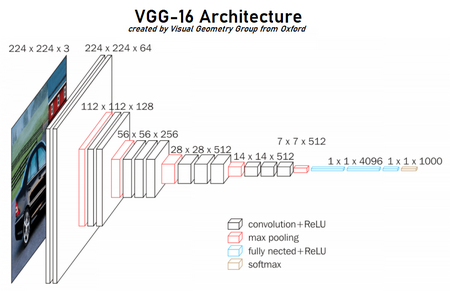

Chargement de VGG-16 pré-entraîné sur ImageNet et sans les couches hautes de classification (propres aux 1000 catégories d'ImageNet)

In [ ]:
from keras.applications.vgg16 import VGG16
VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
# VGG16.summary() # 19 couches sous cette forme (en comptant celles sans paramètres)

Il est possible d'entrainer au choix la totalité du réseau VGG16 ou seulement les couches hautes de classification. La seconde possibilité permet d'utiliser les poids des couches basses issus de l'entrainement sur ImageNet.

Il faut alors éxecuter une des deux cellules uniquement

In [17]:
### Entrainement du classifieur SEULEMENT ###

for layer in VGG16.layers[:19]:
    layer.trainable = False
# Récupérer la sortie de ce réseau
couche = VGG16.output
predictions = Flatten()(couche)
predictions = Dropout(0.05)(predictions)
predictions = Dense(1, activation = 'sigmoid')(predictions)
# Définir le nouveau modèle
VGG16_TL = Model(inputs=VGG16.input, outputs=predictions)
top_train = True ; full_train = False

In [ ]:
### Entrainement COMPLET de VGG16 ###

# Récupérer la sortie de ce réseau
couche = VGG16.output
predictions = Flatten()(couche)
predictions = Dropout(0.05)(predictions)
predictions = Dense(1, activation = 'sigmoid')(predictions)
# Définir le nouveau modèle
VGG16_TL = Model(inputs=VGG16.input, outputs=predictions)
top_train = False ; full_train = True

Compilation du modèle

In [ ]:
# Compiler le modèle 
VGG16_TL.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.SGD(learning_rate=0.000025, momentum=0.9), metrics=["accuracy"])
VGG16_TL.summary()

La cellule suivante lance l'entrainement du réseau sur les données préparées dans la section de pré-traitement. Le paramètre ***epochs*** permet de spécifier à l'algorithme le nombre de fois où il doit "voir" chaque image de ***X_train*** pendant son entrainement.

In [ ]:
history = VGG16_TL.fit(X_train, Y_train, epochs=12, validation_data=(X_test, Y_test))

La cellule suivante permet de visualiser sur des graphiques la progression de l'*Accuracy* et de la *Loss* au fil de l'entrainement. 

Le paramètre ***litter_name*** est une appelation du type de déchets que le réseau s'est entrainé à reconnaitre et apparait sur les graphiques. 

Le paramètre ***save_graphs*** permet s'il est *True* de sauvegarder automatiquement les graphiques dans un dossier sur le *Google Drive* connecté.

In [ ]:
litter_name = "mask"
save_graphs = False

if save_graphs:
    new_folder = path_to_GGDrive + str(datetime.now()).split(".")[0] + "/"
    mkdir(new_folder)

## History for ACCURACY
plt.plot(history.history['accuracy']) ; plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'test'], loc='upper left')
plt.title('VGG16 TL for ' + litter_name + ' - Accuracy')
plt.ylabel('accuracy') ; plt.xlabel('epoch')
if save_graphs:
    plt.savefig(new_folder + "vgg16_" + litter_name.upper() + "_ACC", format="png")
plt.show()
## History for LOSS
plt.plot(history.history['loss']) ; plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper left')
plt.title('VGG16 TL for ' + litter_name + ' - Loss')
plt.ylabel('loss') ; plt.xlabel('epoch')
if save_graphs:
    plt.savefig(new_folder + "vgg16_" + litter_name.upper() + "_LOSS", format="png")
plt.show()

if save_graphs:
    print("Graphiques ACC et LOSS sauvegardés dans '{0}'".format(new_folder))

La cellule suivante permet de sauvegarder le modèle entrainer dans un fichier *.h5* dans le même dossier que les graphiques précédents.

Le nom du fichier indique :
- le type d'entrainement réalisé (*Full Learning* ou *Transfer Learning*
- le type de réseau utilisé (VGG16 ici)
- le type de données utilisées (équilibrées en 50%-50% par rapport à la catégorie ou avec la totalité de la base de données)

In [ ]:
model_name = ""
if top_train:
    model_name += "TL_"
elif full_train:
    model_name += "FL_"
model_name += litter_name.upper() + "_vgg16_"
if labels_50_50:
    model_name += "5050img.h5"
else:
    model_name += "fullimg.h5"

print("Type de déchet : " + litter_name.upper()) ; print("")
VGG16_TL.save(new_folder + model_name)
print("Modele '{0}' sauvegardé dans '{1}'.".format(model_name,new_folder))

La cellule suivante permet de tester le réseau entrainé précédemment en réalisant une prédiction sur une image stockée dans *Google Drive* dont le nom doit être indiquée dans ***nom_image***.

In [ ]:
nom_image = ""

img = load_img(path_to_GGDrive + nom_image, target_size=(224, 224))  # Charger l'image
img = img_to_array(img)  # Convertir en tableau numpy de shape (224,224,3)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
img = prepro_function(img)  # Prétraiter l'image comme le veut VGG-16
pred = VGG16_TL.predict(img)[0]
print(fichier, pred)

# 5.2 - Resnet50

L'organisation du code de cette section est similaire à celui de la section 5.1

In [ ]:
## Charger ResNet-50 pré-entraîné et sans les couches fully-connected
from keras.applications.resnet50 import ResNet50
RESNET50 = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
RESNET50.summary() # 19 couches sous cette forme (en comptant celles sans paramètres)

In [ ]:
### Entrainement du classifieur SEULEMENT
for layer in RESNET50.layers: #[:19]:
    layer.trainable = False

# Récupérer la sortie de ce réseau
couche = RESNET50.output
predictions = Flatten()(couche)
predictions = Dropout(0.05)(predictions)
predictions = Dense(1, activation = 'sigmoid')(predictions)
# Définir le nouveau modèle
RESNET50_TL = Model(inputs=RESNET50.input, outputs=predictions)
top_train = True ; full_train = False

In [ ]:
### Entrainement COMPLET de RESNET50

# Récupérer la sortie de ce réseau
couche = RESNET50.output
predictions = Flatten()(couche)
predictions = Dropout(0.05)(predictions)
predictions = Dense(1, activation = 'sigmoid')(predictions)
# Définir le nouveau modèle
RESNET50_TL = Model(inputs=RESNET50.input, outputs=predictions)
top_train = False ; full_train = True

In [ ]:
# Compiler le modèle 
RESNET50_TL.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])
RESNET50_TL.summary()

In [ ]:
history = RESNET50_TL.fit(X_train, Y_train, epochs=12, validation_data=(X_test, Y_test))

In [ ]:
litter_name = "bottle"
save_graphs = True

if save_graphs:
    new_folder = path_to_GGDrive + str(datetime.now()).split(".")[0] + "/"
    mkdir(new_folder)

## History for ACCURACY
plt.plot(history.history['accuracy']) ; plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'test'], loc='upper left')
plt.title('RESNET50 TL for ' + litter_name + ' - Accuracy')
plt.ylabel('accuracy') ; plt.xlabel('epoch')
if save_graphs:
    plt.savefig(new_folder + "resnet50_" + litter_name.upper() + "_ACC", format="png")
plt.show()
## History for LOSS
plt.plot(history.history['loss']) ; plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper left')
plt.title('RESNET50 TL for ' + litter_name + ' - Loss')
plt.ylabel('loss') ; plt.xlabel('epoch')
if save_graphs:
    plt.savefig(new_folder + "resnet50_" + litter_name.upper() + "_LOSS", format="png")
plt.show()

if save_graphs:
    print("Graphiques ACC et LOSS sauvegardés dans '{0}'".format(new_folder))

In [ ]:
model_name = ""
if top_train:
    model_name += "TL_"
else:
    model_name += "FL_"
model_name += litter_name.upper() + "_resnet50_"
if labels_50_50:
    model_name += "5050img.h5"
else:
    model_name += "fullimg.h5"

print("Type de déchet : " + litter_name.upper()) ; print("")
RESNET50_TL.save(new_folder + model_name)
print("Modele '{0}' sauvegardé dans '{1}'.".format(model_name,new_folder))

In [ ]:
nom_image = ""

img = load_img(path_to_GGDrive + nom_image, target_size=(224, 224))  # Charger l'image
img = img_to_array(img)  # Convertir en tableau numpy de shape (224,224,3)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
img = prepro_RESNET50(img)  # Prétraiter l'image comme le veut VGG-16
pred = RESNET50_TL.predict(img)[0]
print(fichier, pred)

# 5.3 EfficientNetB3

L'organisation du code de cette section est similaire à celui de la section 5.1

In [ ]:
## Charger EfficientNetB3 pré-entraîné et sans les couches fully-connected
from keras.applications.EfficientNetB3 import EfficientNetB3
EFFICIENTNETB3 = keras.applications.EfficientNetB3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
# EFFICIENTNETB3.summary()


In [ ]:
### Entrainement du classifieur SEULEMENT
for layer in EFFICIENTNETB3.layers: #[:19]:
    layer.trainable = False

# Récupérer la sortie de ce réseau
couche = EFFICIENTNETB3.output
predictions = Flatten()(couche)
predictions = Dropout(0.05)(predictions)
predictions = Dense(1, activation = 'sigmoid')(predictions)
# Définir le nouveau modèle
EFFICIENTNETB3_TL = Model(inputs=EFFICIENTNETB3.input, outputs=predictions)
top_train = True ; full_train = False

In [ ]:
### Entrainement COMPLET de EFFICIENTNETB3

# Récupérer la sortie de ce réseau
couche = EFFICIENTNETB3.output
predictions = Flatten()(couche)
predictions = Dropout(0.05)(predictions)
predictions = Dense(1, activation = 'sigmoid')(predictions)
# Définir le nouveau modèle
EFFICIENTNETB3_TL = Model(inputs=EFFICIENTNETB3.input, outputs=predictions)
top_train = False ; full_train = True

In [ ]:
# Compiler le modèle 
EFFICIENTNETB3_TL.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])
EFFICIENTNETB3_TL.summary()

In [ ]:
history = EFFICIENTNETB3_TL.fit(X_train, Y_train, epochs=22, validation_data=(X_test, Y_test))

In [ ]:
litter_name = "bottle"
save_graphs = True

if save_graphs:
    new_folder = path_to_GGDrive + str(datetime.now()).split(".")[0] + "/"
    mkdir(new_folder)

## History for ACCURACY
plt.plot(history.history['accuracy']) ; plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'test'], loc='upper left')
plt.title('EFFICIENTNETB3 TL for ' + litter_name + ' - Accuracy')
plt.ylabel('accuracy') ; plt.xlabel('epoch')
if save_graphs:
    plt.savefig(new_folder + "efficientnetb3_" + litter_name.upper() + "_ACC", format="png")
plt.show()
## History for LOSS
plt.plot(history.history['loss']) ; plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper left')
plt.title('EFFICIENTNETB3 TL for ' + litter_name + ' - Loss')
plt.ylabel('loss') ; plt.xlabel('epoch')
if save_graphs:
    plt.savefig(new_folder + "efficientnetb3_" + litter_name.upper() + "_LOSS", format="png")
plt.show()

if save_graphs:
    print("Graphiques ACC et LOSS sauvegardés dans '{0}'".format(new_folder))

In [ ]:
model_name = ""
if top_train:
    model_name += "TL_"
else:
    model_name += "FL_"
model_name += litter_name.upper() + "_efficientnetb3_"
if labels_50_50:
    model_name += "5050img.h5"
else:
    model_name += "fullimg.h5"

print("Type de déchet : " + litter_name.upper()) ; print("")
EFFICIENTNETB3_TL.save(new_folder + model_name)
print("Modele '{0}' sauvegardé dans '{1}'.".format(model_name,new_folder))

In [ ]:
nom_image = ""

img = load_img(path_to_GGDrive + nom_image, target_size=(224, 224))  # Charger l'image
img = img_to_array(img)  # Convertir en tableau numpy de shape (224,224,3)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
img = prepro_EFFICIENTNETB3(img)  # Prétraiter l'image comme le veut VGG-16
pred = EFFICIENTNETB3_TL.predict(img)[0]
print(fichier, pred)

# 6 - Interprétation des prédictions avec LIME


Chargement du modèle VGG16 à tester.

Il est aussi possible de tester d'autres modèles à condition de changer la fonction de preprocess dans *predict_fn*.

In [ ]:
model_name = 'SAVED_MODELS/25_05_2021/full_TL_PLASTIC_CONTAINER_AND_OTHER_vgg16_5050img.h5'
litter_cat = "PLASTIC_CONTAINER_AND_OTHER"
VGG16_model = tf.keras.models.load_model(path_to_GGDrive + model_name)
print("Modèle '" + model_name + "' chargé.")

In [ ]:
# LIME imports
from skimage.segmentation import mark_boundaries
from lime import lime_image
LIME_explainer = lime_image.LimeImageExplainer()

# Fonctions utiles
def predict_fn(x):
    return(VGG16_model.predict(prepro_VGG16(x)))

def add_mask(np_img, mask, np_color = np.array([255, 242, 0])):
    l,c = mask.shape
    for y in range(0,l):
        for x in range(0,c):
            if (mask[y][x] != 0):
                np_img[y][x] = np_color
    return(np_img)

Réaliser une prédiction

In [ ]:
img_test_name = "mask_6.jpg"

img = load_img(path_to_GGDrive + "WEB_data/" + img_test_name, target_size=(224, 224))  # Charger l'image
original_np_img = np.array(img)
img = img_to_array(img)  # Convertir en tableau numpy de shape (224,224,3)
prepro_img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
prepro_img = prepro_VGG16(prepro_img)  # Prétraiter l'image comme le veut VGG-16
img_pred = VGG16_model.predict(prepro_img)[0][0] # float qui donne la proba d'être classé positif

# Prediction
plt.imshow(original_np_img) ; plt.xlabel(img_test_name)
plt.title("{0} : {1}".format(litter_cat,img_pred)) ; plt.show()

Analyser les raisons de la prédiction

In [ ]:
start_t = time()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
img_explanation = LIME_explainer.explain_instance(img, predict_fn)#, top_labels=1, hide_color=0, num_samples=1000)
print("Analyse de la prédiction terminée.")
print("Execution time : " + str(to_percent(time()-start_t,nb_dec=2)/100) + "s")

Afficher les pixels de décision

In [ ]:
temp, mask = img_explanation.get_image_and_mask(0, positive_only=True, num_features=26, hide_rest=False) # 'num_features' = une certaine quantité de pixels jaune à afficher
img_with_mask = add_mask(original_np_img.copy(),mask)
print("[Les parties jaunes de l'image sont les principales responsables de la prise de décision du réseau]") ; print("")

## MASK sur image originale
plt.imshow(img_with_mask)
## MASK sur image pré-traité
# plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

plt.xlabel(img_test_name) ; plt.title("{0} : {1}".format(litter_cat,img_pred)) ; plt.show()
